In [1]:
import os
import numpy as np
import pandas as pd
import time
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [47]:
train_images = os.listdir('train_v2')

In [48]:
train_images.sort()
# train_images = np.array(train_images)
# print(train_images.shape)

In [49]:
image_ids = [file for file in os.listdir('train_v2') if file.endswith('.jpg')]
len(image_ids)

24

In [50]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')

In [51]:
masks.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [52]:
filtered_df = masks[masks['ImageId'].isin(image_ids)]

In [53]:
filtered_df

ImageId                                      EncodedPixels
0   00003e153.jpg                                                NaN
1   0001124c7.jpg                                                NaN
2   000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3   000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4   000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5   000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6   000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7   000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8   0001b1832.jpg                                                NaN
9   00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...
10  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
11  00021ddc3.jpg  74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
12  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
13  00021ddc3.jpg  150423 2 151190 3 151958 3 152726 4 153495 3 1...
14  00021ddc3.jpg  139644 2 140408 6 141174 9 141942 9 142711 6 1...
15  00021ddc3.jpg  75972 3 76738 5 77506 5 78274 5 79042 6 79811 ...
16  00021ddc3.jpg  86727 2 87493 4 88261 4 89030 3 89798 4 90566 ...
17  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
18  0002756f7.jpg  255784 2 256552 4 257319 7 258087 9 258854 12 ...
19  0002756f7.jpg  248878 1 249645 4 250413 6 251180 9 251948 10 ...
20  0002d0f32.jpg                                                NaN
21  000303d4d.jpg                                                NaN
22  00031f145.jpg  340363 1 341129 4 341896 6 342663 7 343429 10 ...
23  00052ed46.jpg                                                NaN
24  000532683.jpg  458957 14 459725 14 460493 14 461261 14 462029...
25  000532683.jpg  567543 2 568309 4 569077 5 569846 4 570614 5 5...
26  00053c6ba.jpg  565382 3 566144 9 566909 12 567677 13 568445 1...
27  00057a50d.jpg                                                NaN
28  000592296.jpg                                                NaN
29  0005d01c8.jpg  56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
30  0005d01c8.jpg  365871 1 366638 3 367405 6 368173 7 368940 9 3...
31  0005d6d95.jpg  265143 1 265910 4 266678 5 267445 7 268212 10 ...
32  0006c52e8.jpg  146366 1 147132 4 147899 5 148666 7 149432 10 ...
33  0007b8229.jpg                                                NaN
34  000805313.jpg                                                NaN
35  000811bb6.jpg                                                NaN
36  0008d6216.jpg                                                NaN
37  000913daf.jpg                                                NaN
38  000952d51.jpg                                                NaN

In [54]:
# Define functions to do these tasks for all the training images
def rle_decode(mask_rle, shape=(768,768)):
    '''
    Input arguments -
    mask_rle: Mask of one ship in the train image
    shape: Output shape of the image array
    '''
    s = mask_rle.split()                                                               # Split the mask of each ship that is in RLE format
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]     # Get the start pixels and lengths for which image has ship
    ends = starts + lengths - 1                                                        # Get the end pixels where we need to stop
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)                                  # A 1D vec full of zeros of size = 768*768
    for lo, hi in zip(starts, ends):                                                   # For each start to end pixels where ship exists
        img[lo:hi+1] = 1                                                               # Fill those values with 1 in the main 1D vector
    '''
    Returns -
    Transposed array of the mask: Contains 1s and 0s. 1 for ship and 0 for background
    '''
    return img.reshape(shape).T

def masks_as_image(in_mask_list):
    '''
    Input -
    in_mask_list: List of the masks of each ship in one whole training image
    '''
    all_masks = np.zeros((768, 768), dtype = np.int16)                                 # Creating 0s for the background
    for mask in in_mask_list:                                                          # For each ship rle data in the list of mask rle
        if isinstance(mask, str):                                                      # If the datatype is string
            all_masks += rle_decode(mask)                                              # Use rle_decode to create one mask for whole image
    '''
    Returns -
    Full mask of the training image whose RLE data has been passed as an input
    '''
    return np.expand_dims(all_masks, -1)

In [55]:
masks = filtered_df

In [56]:
'''Note that NaN values in the EncodedPixels are of float type and everything else is a string type'''

# Add a new feature to the masks data frame named as ship. If Encoded pixel in any row is a string, there is a ship else there isn't.
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
masks.head(9)

ImageId                                      EncodedPixels  ships
0  00003e153.jpg                                                NaN      0
1  0001124c7.jpg                                                NaN      0
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      1
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      1
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...      1
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...      1
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...      1
8  0001b1832.jpg                                                NaN      0

In [57]:
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids.index+=1 # Incrimenting all the index by 1
unique_img_ids.head(25)

ImageId  ships
1   00003e153.jpg      0
2   0001124c7.jpg      0
3   000155de5.jpg      1
4   000194a2d.jpg      5
5   0001b1832.jpg      0
6   00021ddc3.jpg      9
7   0002756f7.jpg      2
8   0002d0f32.jpg      0
9   000303d4d.jpg      0
10  00031f145.jpg      1
11  00052ed46.jpg      0
12  000532683.jpg      2
13  00053c6ba.jpg      1
14  00057a50d.jpg      0
15  000592296.jpg      0
16  0005d01c8.jpg      2
17  0005d6d95.jpg      1
18  0006c52e8.jpg      1
19  0007b8229.jpg      0
20  000805313.jpg      0
21  000811bb6.jpg      0
22  0008d6216.jpg      0
23  000913daf.jpg      0
24  000952d51.jpg      0

In [58]:
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids.head(25)

ImageId  ships  has_ship
1   00003e153.jpg      0       0.0
2   0001124c7.jpg      0       0.0
3   000155de5.jpg      1       1.0
4   000194a2d.jpg      5       1.0
5   0001b1832.jpg      0       0.0
6   00021ddc3.jpg      9       1.0
7   0002756f7.jpg      2       1.0
8   0002d0f32.jpg      0       0.0
9   000303d4d.jpg      0       0.0
10  00031f145.jpg      1       1.0
11  00052ed46.jpg      0       0.0
12  000532683.jpg      2       1.0
13  00053c6ba.jpg      1       1.0
14  00057a50d.jpg      0       0.0
15  000592296.jpg      0       0.0
16  0005d01c8.jpg      2       1.0
17  0005d6d95.jpg      1       1.0
18  0006c52e8.jpg      1       1.0
19  0007b8229.jpg      0       0.0
20  000805313.jpg      0       0.0
21  000811bb6.jpg      0       0.0
22  0008d6216.jpg      0       0.0
23  000913daf.jpg      0       0.0
24  000952d51.jpg      0       0.0

In [59]:
# Also, retrive the old masks data frame
masks.drop(['ships'], axis=1, inplace=True)
masks.index+=1
masks.head()

ImageId                                      EncodedPixels
1  00003e153.jpg                                                NaN
2  0001124c7.jpg                                                NaN
3  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
4  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
5  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [60]:
highR = pd.merge(masks, unique_img_ids)
highR.head()

ImageId                                      EncodedPixels  ships  \
0  00003e153.jpg                                                NaN      0   
1  0001124c7.jpg                                                NaN      0   
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...      1   
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...      5   
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...      5   

   has_ship  
0       0.0  
1       0.0  
2       1.0  
3       1.0  
4       1.0

In [124]:
def rle2bbox(rle, shape):
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))
    a[:,0] -= 1
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    xc = (x0+x1)/(2*768)
    yc = (y0+y1)/(2*768)
    w = np.abs(x1-x0)/768
    h = np.abs(y1-y0)/768
    return [xc, yc, h, w]

In [125]:
#Converting from Encoded Pixel to Bounding Box
highR["Boundingbox"] = highR["EncodedPixels"].apply(lambda x:rle2bbox(x,(768,768)) if isinstance(x,str) else np.NaN)
highR.drop("EncodedPixels", axis =1, inplace =True)

In [126]:
highR

ImageId  ships  has_ship  \
0   00003e153.jpg      0       0.0   
1   0001124c7.jpg      0       0.0   
2   000155de5.jpg      1       1.0   
3   000194a2d.jpg      5       1.0   
4   000194a2d.jpg      5       1.0   
5   000194a2d.jpg      5       1.0   
6   000194a2d.jpg      5       1.0   
7   000194a2d.jpg      5       1.0   
8   0001b1832.jpg      0       0.0   
9   00021ddc3.jpg      9       1.0   
10  00021ddc3.jpg      9       1.0   
11  00021ddc3.jpg      9       1.0   
12  00021ddc3.jpg      9       1.0   
13  00021ddc3.jpg      9       1.0   
14  00021ddc3.jpg      9       1.0   
15  00021ddc3.jpg      9       1.0   
16  00021ddc3.jpg      9       1.0   
17  00021ddc3.jpg      9       1.0   
18  0002756f7.jpg      2       1.0   
19  0002756f7.jpg      2       1.0   
20  0002d0f32.jpg      0       0.0   
21  000303d4d.jpg      0       0.0   
22  00031f145.jpg      1       1.0   
23  00052ed46.jpg      0       0.0   
24  000532683.jpg      2       1.0   
25  000532683.jpg      2       1.0   
26  00053c6ba.jpg      1       1.0   
27  00057a50d.jpg      0       0.0   
28  000592296.jpg      0       0.0   
29  0005d01c8.jpg      2       1.0   
30  0005d01c8.jpg      2       1.0   
31  0005d6d95.jpg      1       1.0   
32  0006c52e8.jpg      1       1.0   
33  0007b8229.jpg      0       0.0   
34  000805313.jpg      0       0.0   
35  000811bb6.jpg      0       0.0   
36  0008d6216.jpg      0       0.0   
37  000913daf.jpg      0       0.0   
38  000952d51.jpg      0       0.0   

                                          Boundingbox  
0                                                 NaN  
1                                                 NaN  
2   [0.5149739583333334, 0.62890625, 0.046875, 0.1...  
3   [0.625, 0.38671875, 0.026041666666666668, 0.02...  
4   [0.09830729166666667, 0.4967447916666667, 0.01...  
5   [0.3665364583333333, 0.23372395833333334, 0.01...  
6   [0.09765625, 0.5032552083333334, 0.00130208333...  
7   [0.4557291666666667, 0.244140625, 0.0247395833...  
8                                                 NaN  
9   [0.20638020833333334, 0.9817708333333334, 0.03...  
10  [0.19401041666666666, 0.97265625, 0.0390625, 0...  
11  [0.134765625, 0.9290364583333334, 0.0091145833...  
12  [0.13151041666666666, 0.9342447916666666, 0.00...  
13  [0.2571614583333333, 0.86328125, 0.00520833333...  
14  [0.23893229166666666, 0.8248697916666666, 0.01...  
15  [0.13606770833333334, 0.9225260416666666, 0.00...  
16  [0.15104166666666666, 0.9251302083333334, 0.00...  
17  [0.16796875, 0.9908854166666666, 0.015625, 0.0...  
18  [0.4446614583333333, 0.06380208333333333, 0.03...  
19  [0.4348958333333333, 0.0703125, 0.033854166666...  
20                                                NaN  
21                                                NaN  
22  [0.5950520833333334, 0.18033854166666666, 0.03...  
23                                                NaN  
24  [0.78125, 0.6080729166666666, 0.01822916666666...  
25  [0.9661458333333334, 0.9889322916666666, 0.009...  
26  [0.9680989583333334, 0.17122395833333334, 0.01...  
27                                                NaN  
28                                                NaN  
29  [0.20052083333333334, 0.8704427083333334, 0.18...  
30  [0.6712239583333334, 0.373046875, 0.08984375, ...  
31  [0.462890625, 0.23502604166666666, 0.024739583...  
32  [0.3880208333333333, 0.435546875, 0.3580729166...  
33                                                NaN  
34                                                NaN  
35                                                NaN  
36                                                NaN  
37                                                NaN  
38                                                NaN

In [127]:
highR["BoundingboxArea"]=highR["Boundingbox"].map(lambda x:x[2]*768*x[3]*768 if x==x else 0)

In [134]:
os.makedirs('train_v2_labels',exist_ok=True)

In [136]:
def is_valid_bbox(bbox):
    if isinstance(bbox, list) or isinstance(bbox, pd.Series):
        return len(bbox) == 4 and all(pd.notna(val) for val in bbox)
    return False

# Class id for ships
class_id = 0

for image_id, group in highR.groupby('ImageId'):
    if group['has_ship'].any():
        with open(f'train_v2_labels/{image_id}.txt', 'w') as file:
            for _, row in group.iterrows():
                if is_valid_bbox(row['Boundingbox']):
                    bbox = ' '.join(map(str, row['Boundingbox']))
                    yolo_format = f"{class_id} {bbox}\n"

            
                    file.write(yolo_format)


In [25]:
# Function to add Gaussian noise
def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype('uint8')

### ESRGAN

In [143]:
#Loads image from path and preprocesses to make it model ready
def preprocess_image(input_image_path):
    original_image = tf.image.decode_image(tf.io.read_file(input_image_path))
    # Remove the alpha channel if present
    if original_image.shape[-1] == 4:
        original_image = original_image[..., :-1]
    # Ensure the image dimensions are multiples of 4
    image_dimensions = (tf.convert_to_tensor(original_image.shape[:-1]) // 4) * 4
    cropped_image = tf.image.crop_to_bounding_box(original_image, 0, 0, image_dimensions[0], image_dimensions[1])
    float_image = tf.cast(cropped_image, tf.float32)
    # Add a batch dimension
    batched_image = tf.expand_dims(float_image, 0)
    return batched_image

In [144]:
#Saves unscaled Tensor Images.
def save_image(image, filename):

    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save(filename)


In [145]:
%matplotlib inline
#Plots images from image tensors.
def plot_image(tensor, title=""):
    numpy_image = np.asarray(tensor)
    # Ensure pixel values are within the 0-255 range
    normalized_image = tf.clip_by_value(numpy_image, 0, 255)
    display_image = Image.fromarray(tf.cast(normalized_image, tf.uint8).numpy())
    plt.imshow(display_image)
    plt.axis("off")  
    plt.title(title)

In [146]:
# Scales down images using bicubic downsampling.
def downscale_image(tensor_image):
    if len(tensor_image.shape) == 3:
        height, width = tensor_image.shape[:2]
    else:
        raise ValueError("Dimension mismatch. Function is applicable only on single images.")
    # Ensure the pixel values are in the 0-255 range and convert to uint8
    normalized_image = tf.squeeze(tf.cast(tf.clip_by_value(tensor_image, 0, 255), tf.uint8))

    # Calculate the new dimensions and apply bicubic downsampling
    new_dimensions = (width // 4, height // 4)
    downscaled_image = np.asarray(Image.fromarray(normalized_image.numpy()).resize(new_dimensions, Image.BICUBIC))
    
    tensor_format_image = tf.expand_dims(downscaled_image, 0)
    tensor_format_image = tf.cast(tensor_format_image, tf.float32)

    return tensor_format_image

### Single Image

In [147]:
image_path = "train_v2/00003e153.jpg"
model_path = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [148]:
hr_image = preprocess_image(image_path)

#### Input Image 

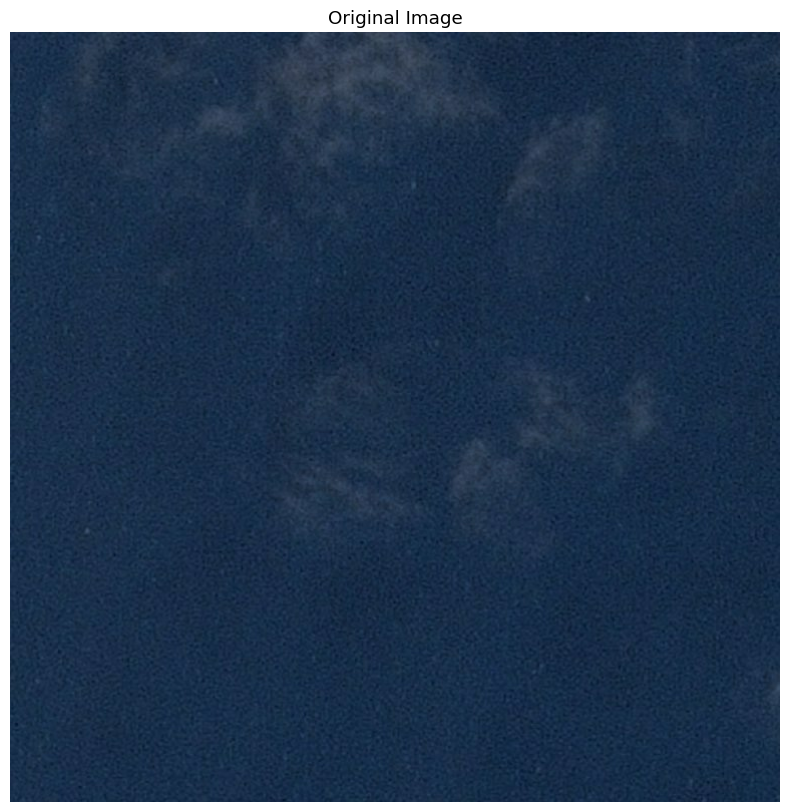

In [149]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image.jpg")

#### Loading the model

In [150]:
ESRGAN = hub.load(model_path)

#### Lower Resolution

In [151]:
#Downscaling the input image to make Low Resolution Image using Bicubic
lr_image = downscale_image(tf.squeeze(hr_image))
save_image(tf.squeeze(lr_image), filename="LowImage.jpg")

C:\Users\satvi\AppData\Local\Temp\ipykernel_21844\2637646636.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  downscaled_image = np.asarray(Image.fromarray(normalized_image.numpy()).resize(new_dimensions, Image.BICUBIC))


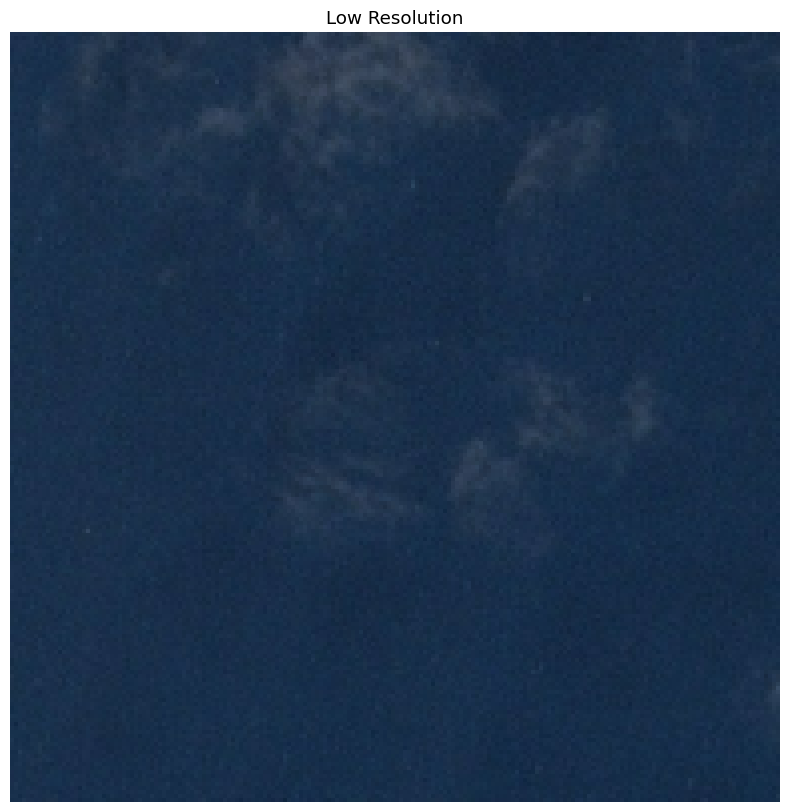

In [152]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [153]:
# Using ESRGAN model to convert lower resolution image to super resolution 
start = time.time()
sr_image = ESRGAN(lr_image)
sr_image = tf.squeeze(sr_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.595256


#### Super Resolution Image

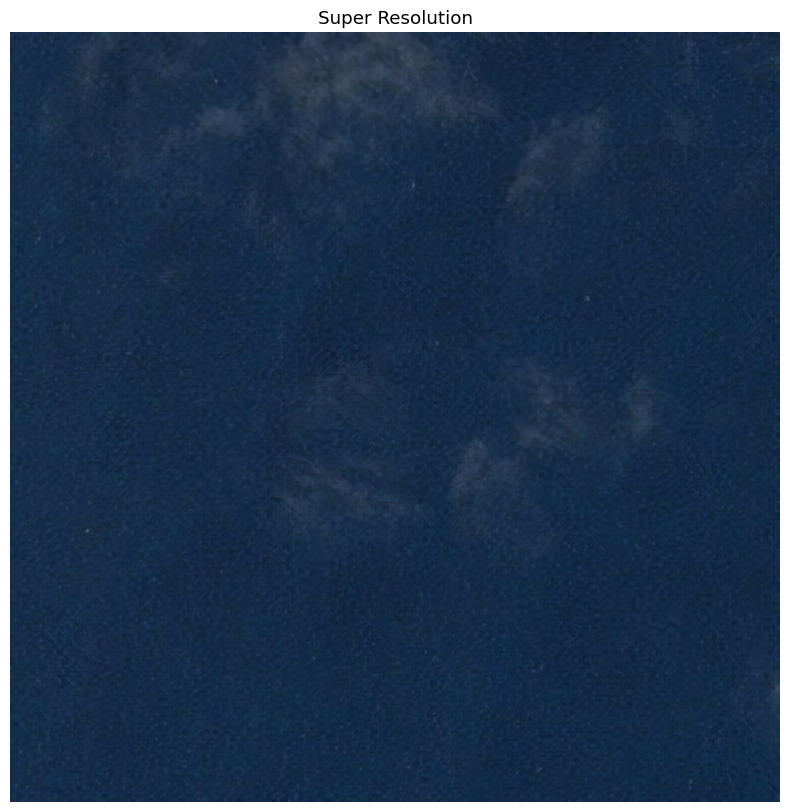

In [154]:
plot_image(tf.squeeze(sr_image), title="Super Resolution")
save_image(tf.squeeze(sr_image), filename="Super Resolution.jpg")

In [155]:
#PSNR between input image and super resolution image
psnr = tf.image.psnr(tf.clip_by_value(sr_image, 0, 255),tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 34.840679


### Plots

PSNR: 34.840679


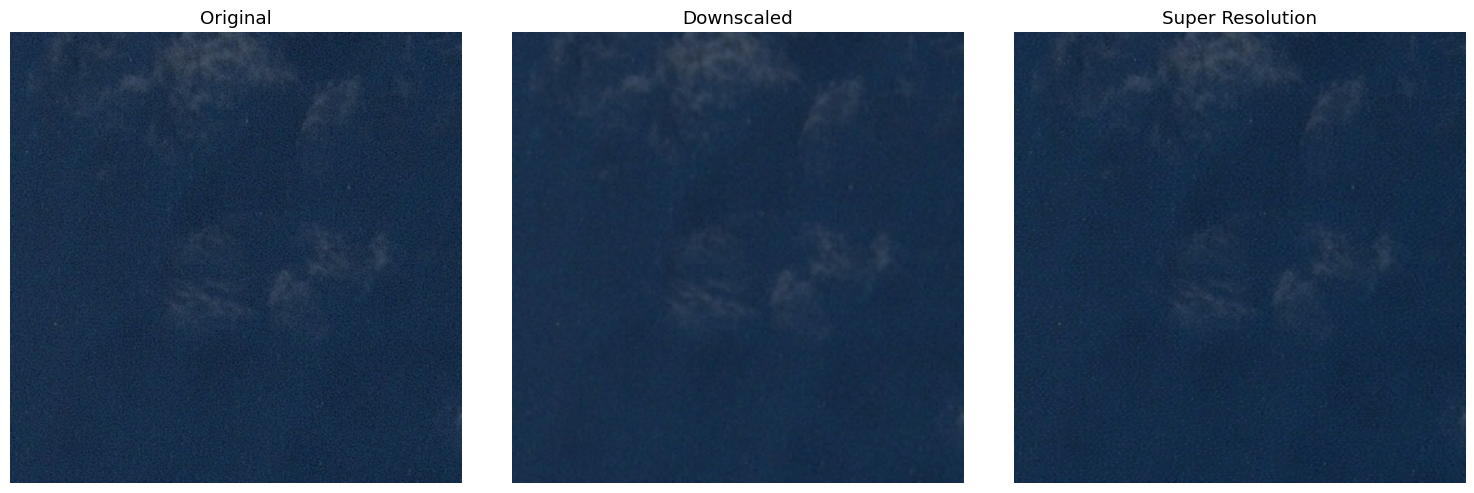

In [156]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "Downscaled")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(sr_image), "Super Resolution")
plt.savefig("side_by_side.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

#### Using ESRGAN to make the training set super resolution

In [74]:
# Create a folder for the low-resolution images
os.makedirs('train_v2_down', exist_ok=True)
os.makedirs('train_v2_super', exist_ok=True)

In [159]:
hr_list = os.listdir("train_v2")
hr_images = []
for img in hr_list:
    if img.split('.')[-1]=='jpg':
        hr_image = cv2.imread("train_v2/" + img)
        lr_image = downscale_image(tf.squeeze(hr_image))
        save_image(tf.squeeze(lr_image), filename="train_v2_down/"+img)
        sr_image = ESRGAN(lr_image)
        sr_image = tf.squeeze(sr_image)
        save_image(tf.squeeze(sr_image), filename="train_v2_super/"+img)    

C:\Users\satvi\AppData\Local\Temp\ipykernel_21844\2637646636.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  downscaled_image = np.asarray(Image.fromarray(normalized_image.numpy()).resize(new_dimensions, Image.BICUBIC))


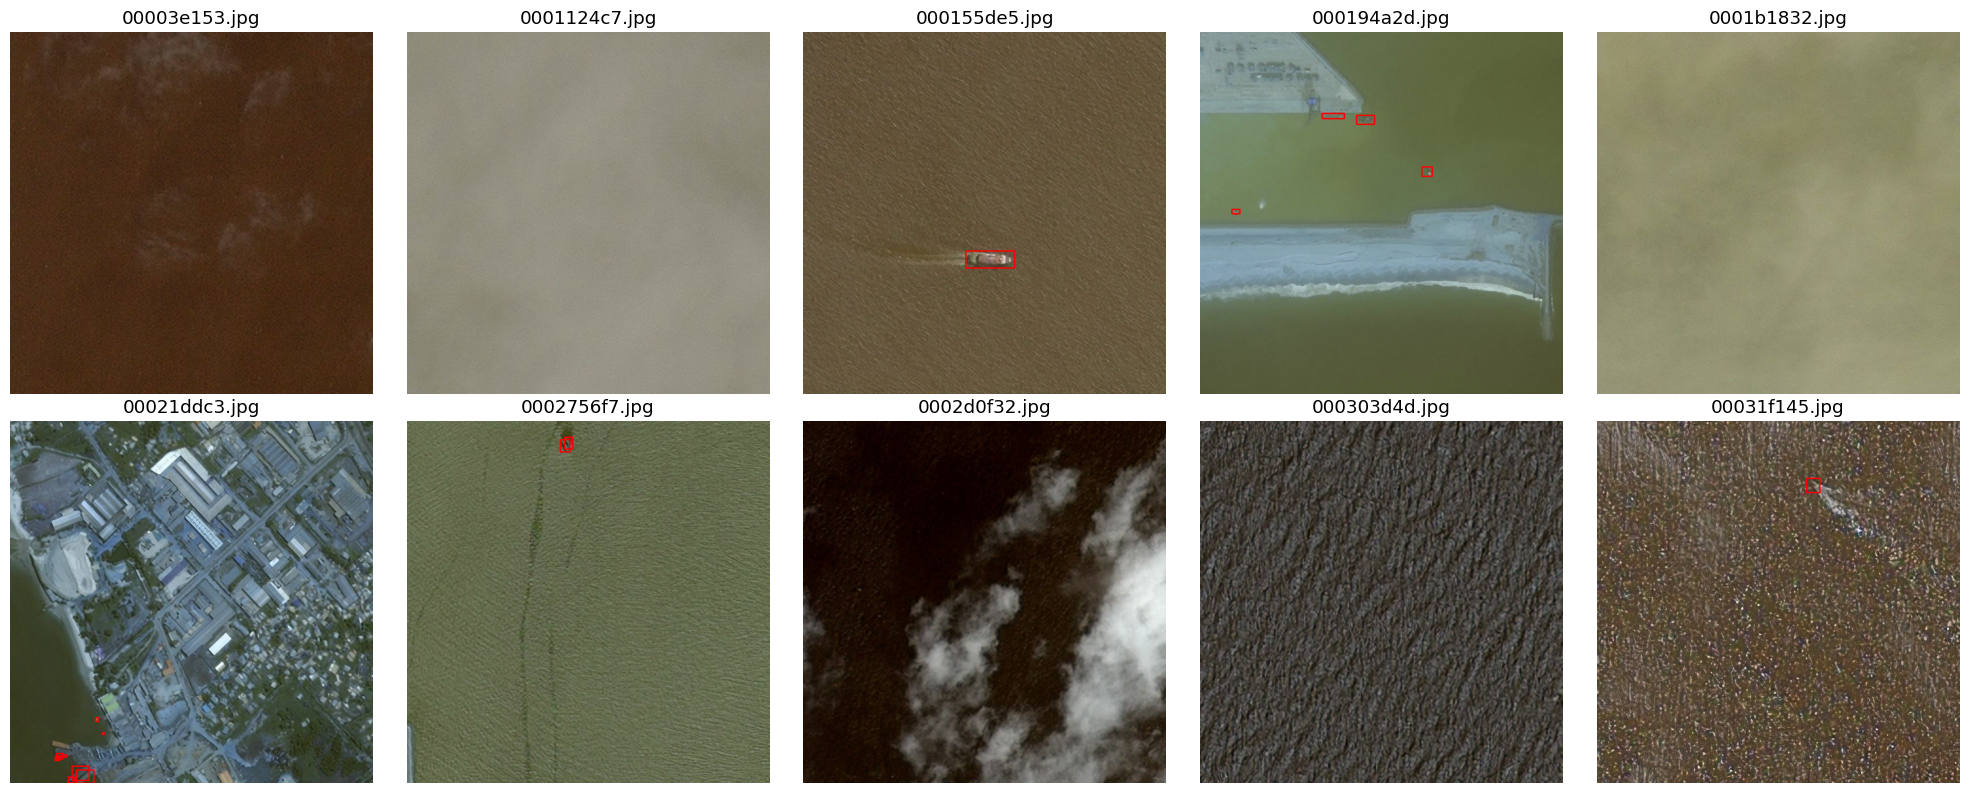

In [173]:
# Function to draw bounding boxes on an image
def draw_bounding_boxes(image_path, bounding_boxes):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for bbox in bounding_boxes:
        if not np.isnan(bbox).any():
            x_center, y_center, width, height = bbox
            x1  = int((x_center-height/2)*image.shape[0])
            y1  = int((y_center-width/2)*image.shape[1])
            x2  = int((x_center+height/2)*image.shape[0])
            y2  = int((y_center+width/2)*image.shape[1])
            cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),thickness = 2)

    return image

# Directory of your images
image_directory = 'train_v2_super'

unique_images = highR['ImageId'].unique()[:10]
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns

for i, image_id in enumerate(unique_images):
    # Get bounding boxes for this image
    bboxes = highR[highR['ImageId'] == image_id]['Boundingbox'].tolist()
    img_with_boxes = draw_bounding_boxes(f"{image_directory}/{image_id}", bboxes)

    
    ax = axes[i // 5, i % 5]
    ax.imshow(img_with_boxes)
    ax.axis('off')
    ax.set_title(image_id)

plt.tight_layout()
plt.show()

### Getting Images with Ships for testing YOLO